In [1]:
!pip install tensorflow scikit-image opencv-python scikit-learn tabulate

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [3]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
# Flatten labels
y_train = y_train.ravel()
y_test = y_test.ravel()

In [5]:
# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

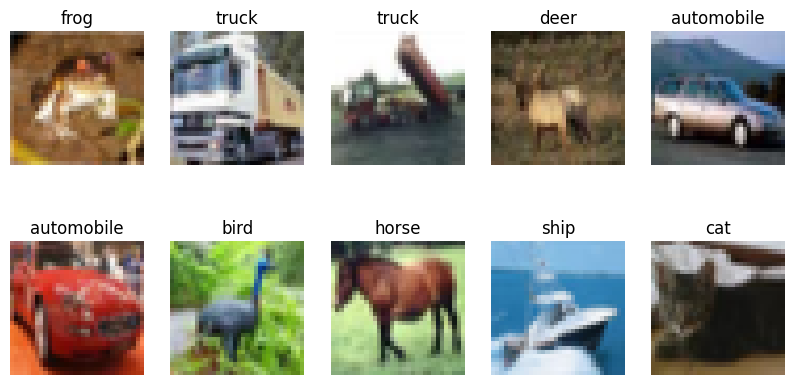

In [6]:
# Display sample images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()

In [7]:
# Preprocess images: Convert to grayscale and resize
def preprocess_images(images, size=(32, 32)):
    processed_images = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        resized_img = cv2.resize(gray_img, size)
        processed_images.append(resized_img)
    return np.array(processed_images)

x_train_processed = preprocess_images(x_train)
x_test_processed = preprocess_images(x_test)

In [8]:
# Normalize pixel values
x_train_processed = x_train_processed / 255.0
x_test_processed = x_test_processed / 255.0

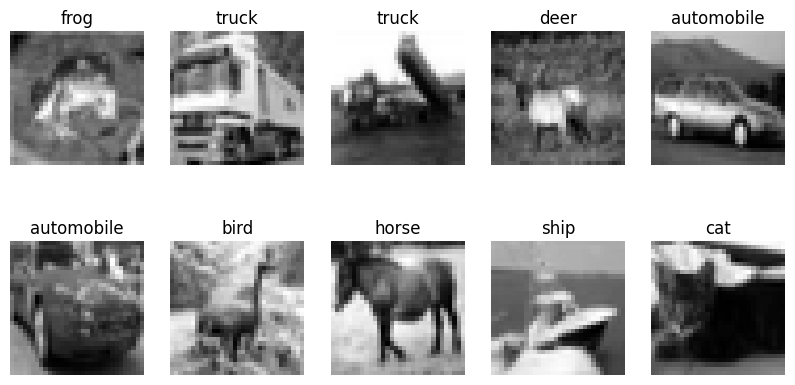

In [9]:
# Display preprocessed images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_processed[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()

3. Feature Extraction

3.1 Histogram of Oriented Gradients (HOG)

In [10]:
# Extract HOG features
def extract_hog_features(images):
    hog_features = []
    for img in images:
        fd, hog_image = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None)
        hog_features.append(fd)
    return np.array(hog_features)

x_train_hog = extract_hog_features(x_train_processed)
x_test_hog = extract_hog_features(x_test_processed)

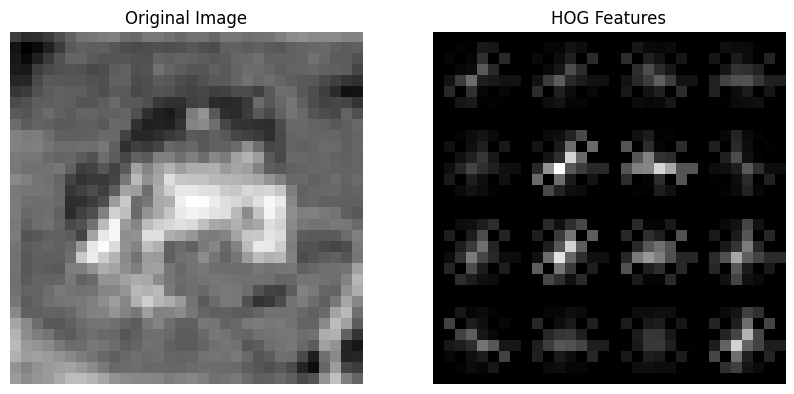

In [11]:
# Display HOG features for a sample image
sample_hog, hog_image = hog(x_train_processed[0], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_train_processed[0], cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Features')
plt.axis('off')
plt.show()

 3.2 Local Binary Patterns (LBP)

In [12]:
# Extract LBP features
def extract_lbp_features(images, P=8, R=1):
    lbp_features = []
    for img in images:
        lbp = local_binary_pattern(img, P=P, R=R, method="uniform")
        hist, _ = np.histogram(lbp, bins=np.arange(0, P + 3), range=(0, P + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # Normalize
        lbp_features.append(hist)
    return np.array(lbp_features)

x_train_lbp = extract_lbp_features(x_train_processed)
x_test_lbp = extract_lbp_features(x_test_processed)

c:\Users\dell9\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


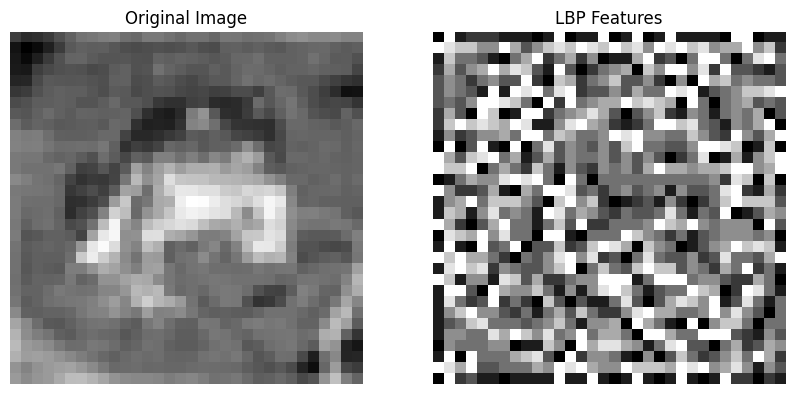

In [13]:
# Display LBP features for a sample image
sample_lbp = local_binary_pattern(x_train_processed[0], P=8, R=1, method="uniform")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_train_processed[0], cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sample_lbp, cmap='gray')
plt.title('LBP Features')
plt.axis('off')
plt.show()

3.3 Edge Detection (Canny)

In [14]:
def extract_edge_features(images):
    edge_features = []
    for img in images:
        # Scale image back to [0, 255] and convert to 8-bit unsigned integer
        img_scaled = (img * 255).astype(np.uint8)
        edges = cv2.Canny(img_scaled, threshold1=100, threshold2=200)
        edge_features.append(edges.flatten())
    return np.array(edge_features)

x_train_edges = extract_edge_features(x_train_processed)
x_test_edges = extract_edge_features(x_test_processed)

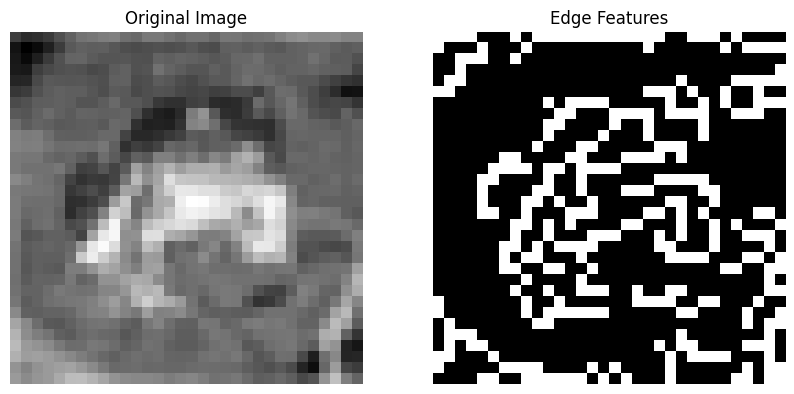

In [15]:
# Display Edge features for a sample image
sample_edges = cv2.Canny((x_train_processed[0] * 255).astype(np.uint8), threshold1=100, threshold2=200)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_train_processed[0], cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sample_edges, cmap='gray')
plt.title('Edge Features')
plt.axis('off')
plt.show()

3.4 Deep Learning-Based Feature Extraction (ResNet)

In [16]:
# Load pre-trained ResNet50 model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

In [17]:
# Preprocess images for ResNet
x_train_resnet = preprocess_input(x_train)
x_test_resnet = preprocess_input(x_test)

In [18]:
# Extract features
x_train_resnet_features = model.predict(x_train_resnet)
x_test_resnet_features = model.predict(x_test_resnet)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step


In [19]:
# Flatten features
x_train_resnet_features = x_train_resnet_features.reshape(x_train_resnet_features.shape[0], -1)
x_test_resnet_features = x_test_resnet_features.reshape(x_test_resnet_features.shape[0], -1)

4. Train and Evaluate Classifiers

4.1 Logistic Regression on HOG Features

In [20]:
# Train classifier
clf_hog = LogisticRegression(max_iter=1000)
clf_hog.fit(x_train_hog, y_train)

LogisticRegression(max_iter=1000)

In [21]:
# Evaluate
y_pred_hog = clf_hog.predict(x_test_hog)
print("HOG + Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_hog))
print(classification_report(y_test, y_pred_hog, target_names=class_names))

HOG + Logistic Regression Accuracy: 0.519
              precision    recall  f1-score   support

    airplane       0.59      0.58      0.59      1000
  automobile       0.58      0.61      0.60      1000
        bird       0.45      0.41      0.43      1000
         cat       0.40      0.30      0.34      1000
        deer       0.44      0.47      0.46      1000
         dog       0.44      0.42      0.43      1000
        frog       0.50      0.62      0.55      1000
       horse       0.58      0.57      0.57      1000
        ship       0.55      0.55      0.55      1000
       truck       0.62      0.65      0.64      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000



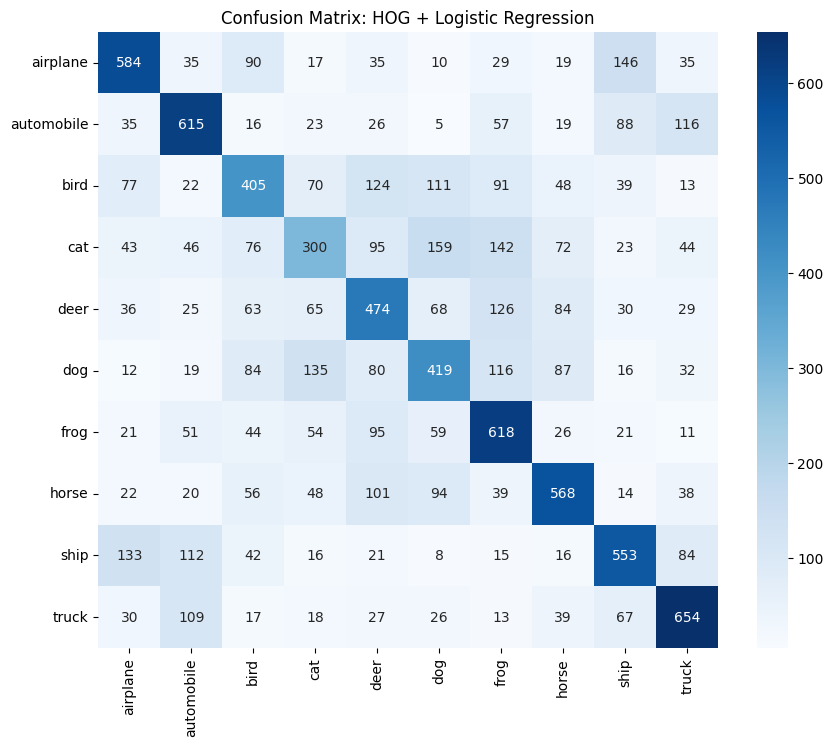

In [22]:
# Confusion Matrix
cm_hog = confusion_matrix(y_test, y_pred_hog)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_hog, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: HOG + Logistic Regression')
plt.show()

4.2 KNN on LBP Features

In [23]:
# Train KNN classifier on LBP features
clf_lbp = KNeighborsClassifier(n_neighbors=5)  # Define the KNN classifier
clf_lbp.fit(x_train_lbp, y_train)  # Train the classifier

KNeighborsClassifier()

In [24]:
# Evaluate the classifier
y_pred_lbp = clf_lbp.predict(x_test_lbp)  # Predict on the test data
print("LBP + KNN Accuracy:", accuracy_score(y_test, y_pred_lbp))  # Print accuracy
print(classification_report(y_test, y_pred_lbp, target_names=class_names))  # Print classification report

LBP + KNN Accuracy: 0.231
              precision    recall  f1-score   support

    airplane       0.24      0.36      0.29      1000
  automobile       0.23      0.36      0.28      1000
        bird       0.15      0.15      0.15      1000
         cat       0.18      0.17      0.17      1000
        deer       0.28      0.29      0.29      1000
         dog       0.21      0.17      0.19      1000
        frog       0.39      0.35      0.37      1000
       horse       0.20      0.16      0.18      1000
        ship       0.21      0.15      0.17      1000
       truck       0.21      0.15      0.18      1000

    accuracy                           0.23     10000
   macro avg       0.23      0.23      0.23     10000
weighted avg       0.23      0.23      0.23     10000



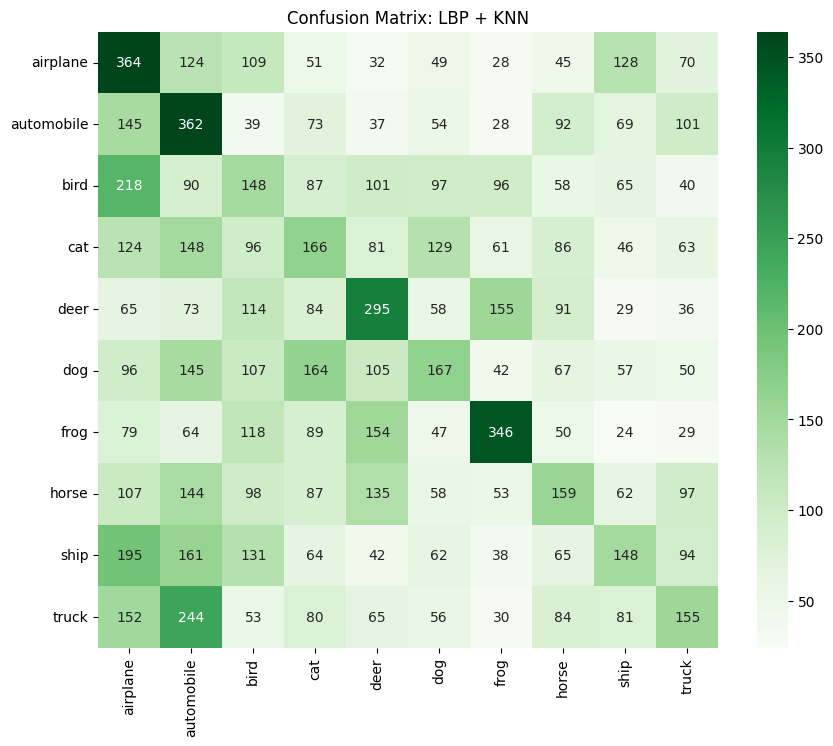

In [25]:
# Confusion Matrix
cm_lbp = confusion_matrix(y_test, y_pred_lbp)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lbp, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: LBP + KNN')
plt.show()

4.3 Random Forest on Edge Features


In [26]:
# Train classifier
clf_edges = RandomForestClassifier(n_estimators=100)
clf_edges.fit(x_train_edges, y_train)

RandomForestClassifier()

In [27]:
# Evaluate
y_pred_edges = clf_edges.predict(x_test_edges)
print("Edge Detection + Random Forest Accuracy:", accuracy_score(y_test, y_pred_edges))
print(classification_report(y_test, y_pred_edges, target_names=class_names))

Edge Detection + Random Forest Accuracy: 0.2385
              precision    recall  f1-score   support

    airplane       0.35      0.42      0.38      1000
  automobile       0.23      0.29      0.26      1000
        bird       0.31      0.32      0.31      1000
         cat       0.13      0.13      0.13      1000
        deer       0.18      0.13      0.15      1000
         dog       0.17      0.18      0.17      1000
        frog       0.21      0.17      0.19      1000
       horse       0.20      0.18      0.19      1000
        ship       0.33      0.34      0.34      1000
       truck       0.21      0.23      0.22      1000

    accuracy                           0.24     10000
   macro avg       0.23      0.24      0.23     10000
weighted avg       0.23      0.24      0.23     10000



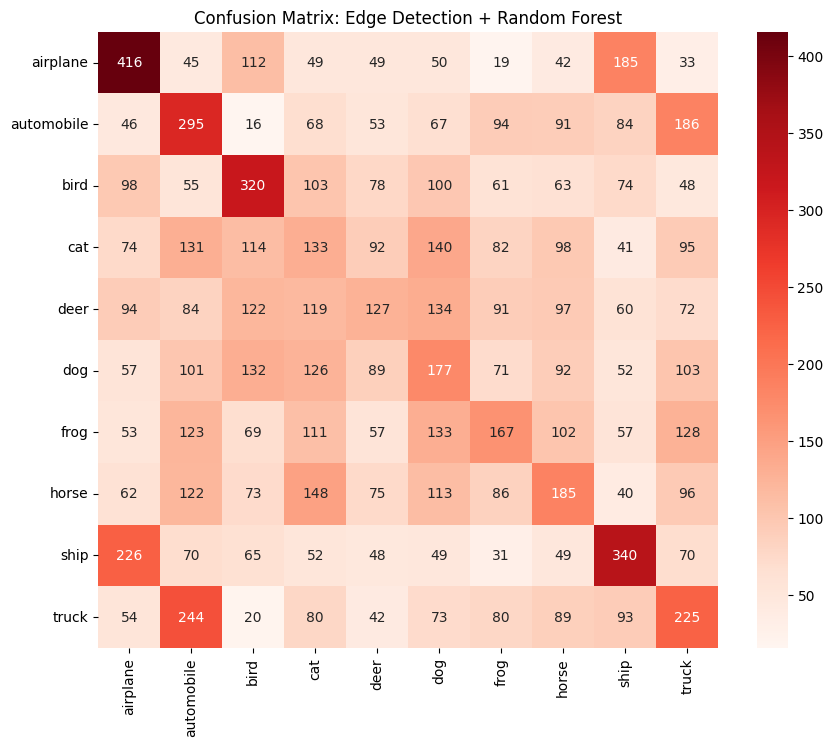

In [28]:
# Confusion Matrix
cm_edges = confusion_matrix(y_test, y_pred_edges)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_edges, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Edge Detection + Random Forest')
plt.show()

4.4 Logistic Regression on ResNet Features

In [29]:
# Train classifier
clf_resnet = LogisticRegression(max_iter=1000)
clf_resnet.fit(x_train_resnet_features, y_train)

c:\Users\dell9\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [30]:
# Evaluate
y_pred_resnet = clf_resnet.predict(x_test_resnet_features)
print("ResNet + Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_resnet))
print(classification_report(y_test, y_pred_resnet, target_names=class_names))

ResNet + Logistic Regression Accuracy: 0.6376
              precision    recall  f1-score   support

    airplane       0.67      0.70      0.68      1000
  automobile       0.71      0.68      0.70      1000
        bird       0.57      0.54      0.55      1000
         cat       0.49      0.47      0.48      1000
        deer       0.59      0.59      0.59      1000
         dog       0.58      0.55      0.57      1000
        frog       0.67      0.73      0.70      1000
       horse       0.68      0.66      0.67      1000
        ship       0.73      0.74      0.74      1000
       truck       0.67      0.71      0.69      1000

    accuracy                           0.64     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.64      0.64      0.64     10000



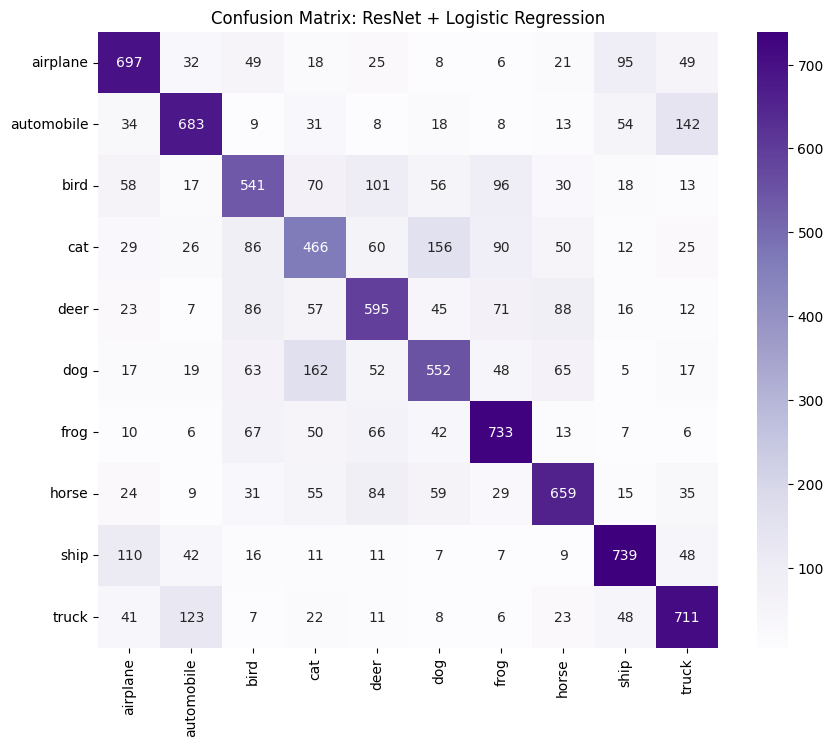

In [31]:
# Confusion Matrix
cm_resnet = confusion_matrix(y_test, y_pred_resnet)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: ResNet + Logistic Regression')
plt.show()

Hybrid Feature Fusion: HOG + ResNet

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [33]:
# 1. Extract HOG features (as before)
x_train_hog = extract_hog_features(x_train_processed)  # (50000, n_hog_features)
x_test_hog = extract_hog_features(x_test_processed)    # (10000, n_hog_features)


In [34]:
# 2. Extract ResNet features (as before)
x_train_resnet_features = model.predict(x_train_resnet).reshape(x_train_resnet.shape[0], -1)
x_test_resnet_features = model.predict(x_test_resnet).reshape(x_test_resnet.shape[0], -1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 242ms/step


In [35]:
# 3. Combine features horizontally
x_train_hybrid = np.hstack([x_train_hog, x_train_resnet_features])  # (50000, n_hog + 2048)
x_test_hybrid = np.hstack([x_test_hog, x_test_resnet_features])     # (10000, n_hog + 2048)

In [36]:
# 4. Normalize and reduce dimensionality (optional but recommended)
pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=128)  # Reduce to 128 dimensions for efficiency
)
x_train_hybrid = pipeline.fit_transform(x_train_hybrid)
x_test_hybrid = pipeline.transform(x_test_hybrid)

In [37]:
# 5. Train a classifier on hybrid features
clf_hybrid = LogisticRegression(max_iter=1000)  # Or use RandomForest/SVM
clf_hybrid.fit(x_train_hybrid, y_train)

LogisticRegression(max_iter=1000)

In [38]:
# 6. Evaluate
y_pred_hybrid = clf_hybrid.predict(x_test_hybrid)
print("Hybrid (HOG+ResNet) Accuracy:", accuracy_score(y_test, y_pred_hybrid))
print(classification_report(y_test, y_pred_hybrid, target_names=class_names))

Hybrid (HOG+ResNet) Accuracy: 0.6702
              precision    recall  f1-score   support

    airplane       0.71      0.72      0.72      1000
  automobile       0.73      0.74      0.74      1000
        bird       0.63      0.54      0.58      1000
         cat       0.53      0.52      0.52      1000
        deer       0.61      0.62      0.62      1000
         dog       0.63      0.58      0.61      1000
        frog       0.69      0.78      0.73      1000
       horse       0.69      0.70      0.70      1000
        ship       0.74      0.74      0.74      1000
       truck       0.72      0.75      0.74      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



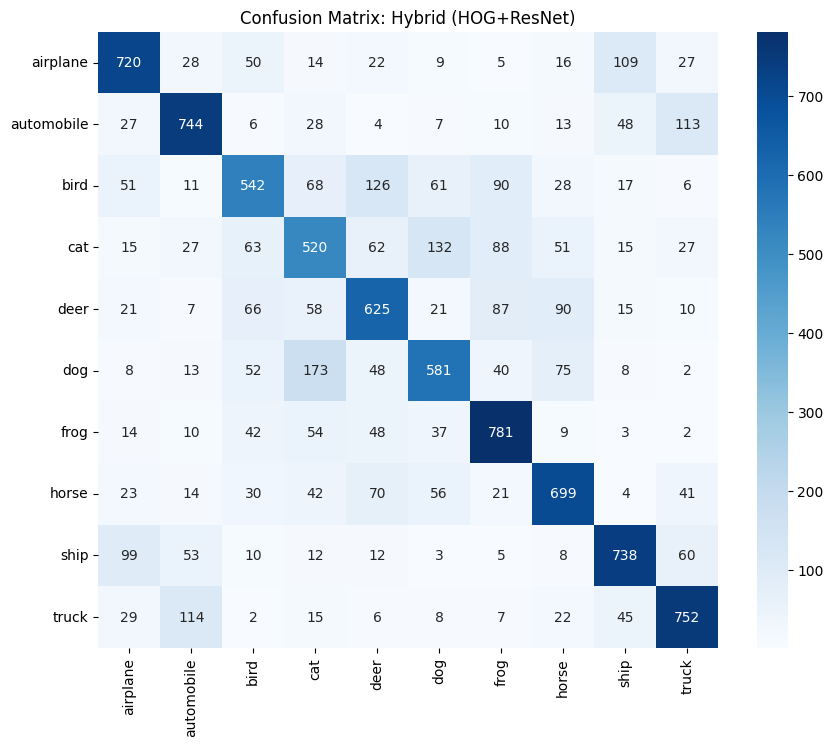

In [39]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_hybrid), 
            annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Hybrid (HOG+ResNet)')
plt.show()

Dynamic Feature Selection 

In [73]:
from tensorflow.keras.layers import Input, Dense, Multiply, Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

In [74]:
# 2. Separate normalization for each feature type
hog_scaler = StandardScaler()
resnet_scaler = StandardScaler()

x_train_hog_scaled = hog_scaler.fit_transform(x_train_hog)
x_train_resnet_scaled = resnet_scaler.fit_transform(x_train_resnet_features)

x_test_hog_scaled = hog_scaler.transform(x_test_hog)
x_test_resnet_scaled = resnet_scaler.transform(x_test_resnet_features)

In [75]:
# 3. Dynamic Feature Selection Model
def build_dynamic_fusion_model(hog_dim, resnet_dim, num_classes):
    hog_input = Input(shape=(hog_dim,), name='hog_input')
    resnet_input = Input(shape=(resnet_dim,), name='resnet_input')
    
    # Attention mechanism
    attention = Dense(hog_dim, activation='sigmoid', name='attention')(resnet_input)
    weighted_hog = Multiply(name='feature_weighting')([hog_input, attention])
    
    # Concatenate
    combined = Concatenate(name='feature_fusion')([weighted_hog, resnet_input])
    
    # Classification
    outputs = Dense(num_classes, activation='softmax', name='output')(combined)
    
    return Model(inputs=[hog_input, resnet_input], outputs=outputs)

In [76]:
# 4. Build model
model = build_dynamic_fusion_model(
    hog_dim=x_train_hog_scaled.shape[1], 
    resnet_dim=x_train_resnet_scaled.shape[1], 
    num_classes=10
)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [77]:
# 5. Train with validation
history = model.fit(
    [x_train_hog_scaled, x_train_resnet_scaled],
    y_train,
    epochs=15,
    batch_size=256,
    validation_data=([x_test_hog_scaled, x_test_resnet_scaled], y_test),
    verbose=1
)

Epoch 1/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5341 - loss: 1.4100 - val_accuracy: 0.6847 - val_loss: 0.9178
Epoch 2/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7508 - loss: 0.7319 - val_accuracy: 0.7079 - val_loss: 0.8556
Epoch 3/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8244 - loss: 0.5391 - val_accuracy: 0.7173 - val_loss: 0.8436
Epoch 4/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8870 - loss: 0.3881 - val_accuracy: 0.7170 - val_loss: 0.8541
Epoch 5/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9375 - loss: 0.2592 - val_accuracy: 0.7153 - val_loss: 0.8810
Epoch 6/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9699 - loss: 0.1699 - val_accuracy: 0.7131 - val_loss: 0.9129
Epoch 7/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9867 - loss: 0.1099 - val_accuracy: 0.7148 - val_loss: 0.9452
Epoch 8/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9946 - loss: 0.0707 - val_accu

KeyboardInterrupt: 

In [65]:
# 6. Evaluation
test_loss, test_acc = model.evaluate([x_test_hog_scaled, x_test_resnet_scaled], y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7176 - loss: 1.1421

Test Accuracy: 0.7185


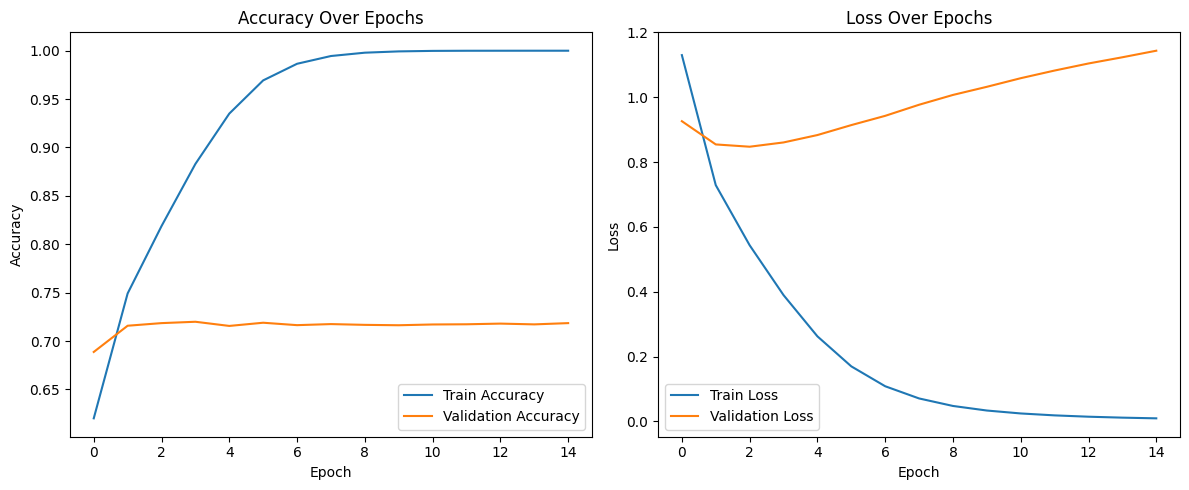

In [66]:
# 7. Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


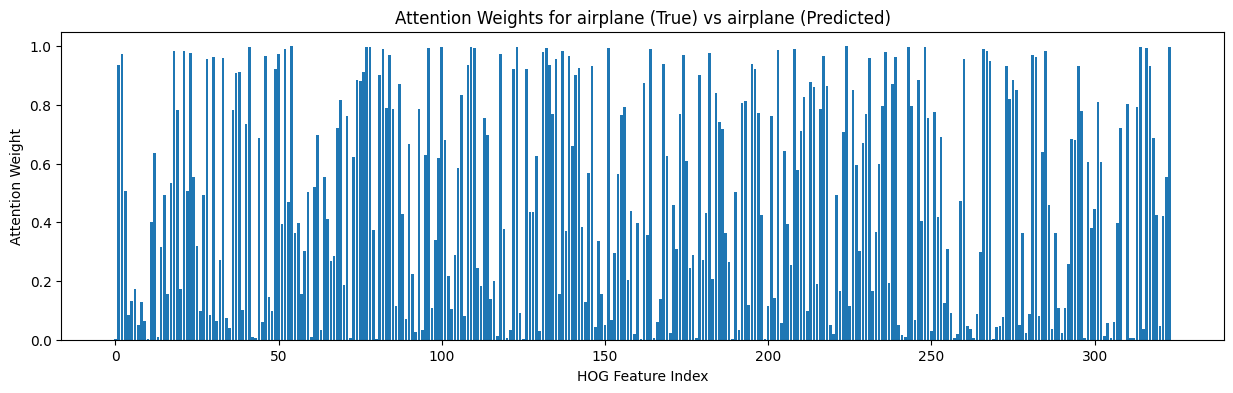

In [67]:
# 8. Attention visualization (for one sample)
sample_idx = 10  # Change to see different examples
attention_model = Model(inputs=model.inputs, outputs=model.get_layer('attention').output)
attention_weights = attention_model.predict([x_test_hog_scaled[sample_idx:sample_idx+1], 
                                          x_test_resnet_scaled[sample_idx:sample_idx+1]])

plt.figure(figsize=(15, 4))
plt.bar(range(x_train_hog_scaled.shape[1]), attention_weights.flatten())
plt.title(f'Attention Weights for {class_names[y_test[sample_idx]]} (True) vs {class_names[np.argmax(model.predict([x_test_hog_scaled[sample_idx:sample_idx+1], x_test_resnet_scaled[sample_idx:sample_idx+1]]))]} (Predicted)')
plt.xlabel('HOG Feature Index')
plt.ylabel('Attention Weight')
plt.show()

Analysis

In [68]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

In [69]:
# =============================================
# 1. Performance Metrics Calculation
# =============================================
def evaluate_model(y_true, y_pred, method_name):
    return {
        "Method": method_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='macro'),
        "Recall": recall_score(y_true, y_pred, average='macro'),
        "F1-Score": f1_score(y_true, y_pred, average='macro')
    }

In [70]:
# =============================================
# 2. Time Tracking Decorator
# =============================================
def time_tracker(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        return result, end_time - start_time
    return wrapper

In [71]:
# =============================================
# 3. Run All Models with Timing
# =============================================
@time_tracker
def run_model(model, x_train, y_train, x_test):
    model.fit(x_train, y_train)
    return model.predict(x_test)

# Models to evaluate
models = {
    "HOG + Logistic Regression": clf_hog,
    "LBP + KNN": clf_lbp,
    "Edge + Random Forest": clf_edges,
    "ResNet + Logistic Regression": clf_resnet,
    "Hybrid (HOG+ResNet)": clf_hybrid
}

# Dynamic Feature Selection (special case)
@time_tracker
def run_dynamic_model():
    history = model.fit(
        [x_train_hog_scaled, x_train_resnet_scaled], y_train,
        epochs=15, batch_size=256, verbose=0
    )
    y_pred = np.argmax(model.predict([x_test_hog_scaled, x_test_resnet_scaled]), axis=1)
    return y_pred

In [78]:
# =============================================
# 4. Evaluate All Models (FIXED VERSION)
# =============================================
results = []
timings = {}

# Feature mapping for both train and test
feature_maps = {
    "HOG": (x_train_hog, x_test_hog),
    "LBP": (x_train_lbp, x_test_lbp),
    "Edge": (x_train_edges, x_test_edges),
    "ResNet": (x_train_resnet_features, x_test_resnet_features),
    "Hybrid": (x_train_hybrid, x_test_hybrid)
}

for name, clf in models.items():
    # Get feature key (extracts "HOG" from "HOG + Logistic Regression")
    feature_key = name.split('+')[0].strip()
    
    # Special handling for hybrid model
    if feature_key not in feature_maps:
        feature_key = "Hybrid"
    
    x_train_feat, x_test_feat = feature_maps[feature_key]
    
    # Train and predict (with timing)
    y_pred, time_taken = run_model(clf, x_train_feat, y_train, x_test_feat)
    
    timings[name] = time_taken
    results.append(evaluate_model(y_test, y_pred, name))

# Dynamic Feature Selection (special handling)
y_pred_dynamic = np.argmax(model.predict([x_test_hog_scaled, x_test_resnet_scaled]), axis=1)
timings["Dynamic Feature Selection"] = 0  # Prediction time only
results.append(evaluate_model(y_test, y_pred_dynamic, "Dynamic Feature Selection"))

c:\Users\dell9\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [81]:
# =============================================
# 5. Display Results
# =============================================
# Performance Metrics Table
print("\n" + "="*60)
print("Classification Performance Comparison")
print("="*60)
print(tabulate(results, headers="keys", tablefmt="grid", floatfmt=".3f"))

# Timing Comparison
timing_data = [{"Method": k, "Time (s)": v} for k,v in timings.items()]
print("\n" + "="*60)
print("Computational Time Comparison")
print("="*60)
print(tabulate(timing_data, headers="keys", tablefmt="grid", floatfmt=".1f"))


Classification Performance Comparison
+------------------------------+------------+-------------+----------+------------+
| Method                       |   Accuracy |   Precision |   Recall |   F1-Score |
+==============================+============+=============+==========+============+
| HOG + Logistic Regression    |      0.519 |       0.515 |    0.519 |      0.516 |
+------------------------------+------------+-------------+----------+------------+
| LBP + KNN                    |      0.231 |       0.230 |    0.231 |      0.226 |
+------------------------------+------------+-------------+----------+------------+
| Edge + Random Forest         |      0.238 |       0.232 |    0.238 |      0.233 |
+------------------------------+------------+-------------+----------+------------+
| ResNet + Logistic Regression |      0.638 |       0.636 |    0.638 |      0.636 |
+------------------------------+------------+-------------+----------+------------+
| Hybrid (HOG+ResNet)          |     

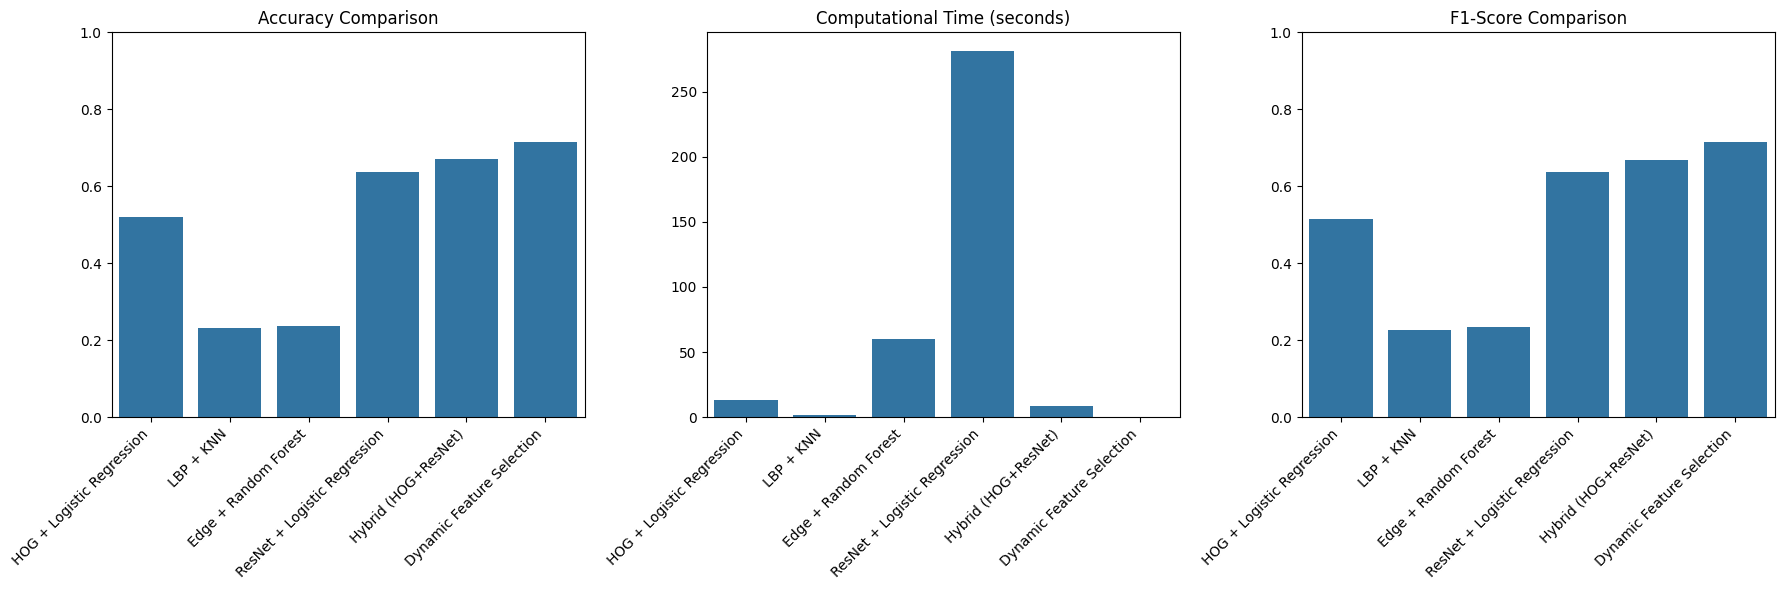

In [82]:
# =============================================
# 6. Visualization
# =============================================
plt.figure(figsize=(18, 6))

# Accuracy Comparison
plt.subplot(1, 3, 1)
sns.barplot(x=[r["Method"] for r in results], y=[r["Accuracy"] for r in results])
plt.title("Accuracy Comparison")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Time Comparison
plt.subplot(1, 3, 2)
sns.barplot(x=list(timings.keys()), y=list(timings.values()))
plt.title("Computational Time (seconds)")
plt.xticks(rotation=45, ha='right')

# F1-Score Comparison
plt.subplot(1, 3, 3)
sns.barplot(x=[r["Method"] for r in results], y=[r["F1-Score"] for r in results])
plt.title("F1-Score Comparison")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


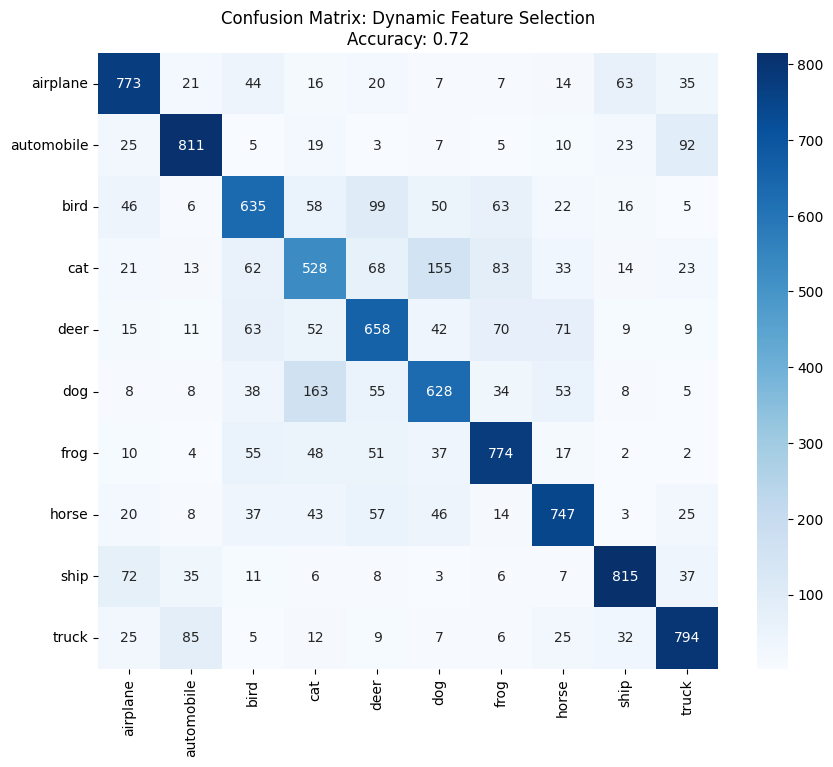

In [83]:
# =============================================
# 7. Confusion Matrix for Best Model
# =============================================
best_model_name = max(results, key=lambda x: x["Accuracy"])["Method"]
if "Dynamic" in best_model_name:
    y_pred_best = y_pred_dynamic
else:
    y_pred_best = models[best_model_name].predict(x_test_hybrid if "Hybrid" in best_model_name else x_test_resnet_features)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix: {best_model_name}\nAccuracy: {accuracy_score(y_test, y_pred_best):.2f}")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


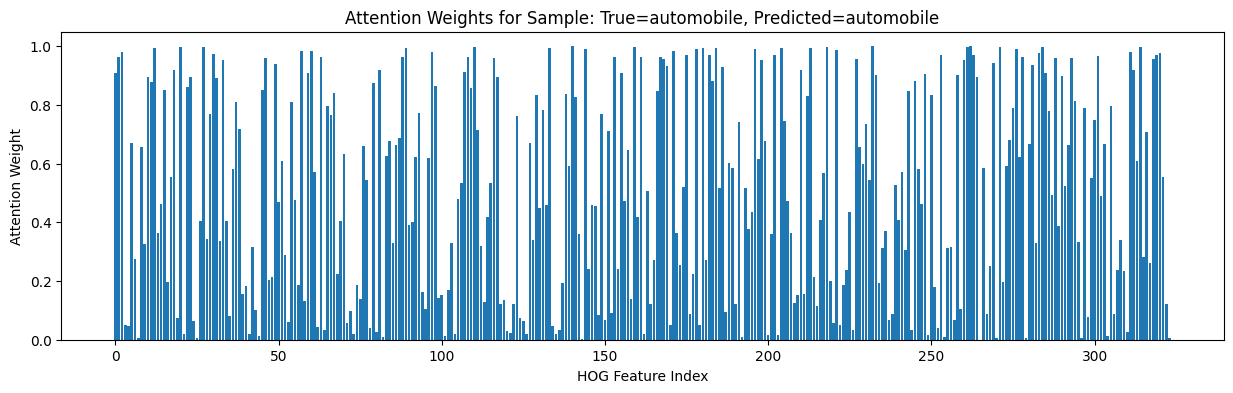

In [84]:
# =============================================
# 8. Attention Weights Visualization (Dynamic Model)
# =============================================
if "Dynamic Feature Selection" in best_model_name:
    sample_idx = np.random.randint(0, len(x_test))
    attention_weights = attention_model.predict([
        x_test_hog_scaled[sample_idx:sample_idx+1],
        x_test_resnet_scaled[sample_idx:sample_idx+1]
    ]).flatten()

    plt.figure(figsize=(15, 4))
    plt.bar(range(len(attention_weights)), attention_weights)
    plt.title(
        f"Attention Weights for Sample: True={class_names[y_test[sample_idx]]}, "
        f"Predicted={class_names[y_pred_dynamic[sample_idx]]}"
    )
    plt.xlabel("HOG Feature Index")
    plt.ylabel("Attention Weight")
    plt.show()